# Assignment

NAME : KUMAR AYUSH

ROLL NUMBER : CH21S016

COURSE : CH5650 , Molecular Data Science and Informatics

GUIDED BY : DR. TARAK K. PATRA SIR

Given : A crystal dataset of 215 optimized structures are provided. All of them are given in the
        POSCAR format. The origin of the structures and calculated properties are given in the first
        line of each structure files as #! label, atEnergy (eV), egap (eV), eps_elec, eps_ion, eps_tot.

Task : Build machine learning models using the given data to predict atomization energy, energy band
       gap, electronic part of the dielectric constant, ionic part of the dielectric constant and total
       dielectric constant of a molecular crystal.


# FEATURES : ZEROTH  ORDER FINGERPRINT f(0)

The simplest (zeroth-order) fingerprint f (0) represents the
fractions of all the element types  existing in the structures.

This fingerprint is a three-dimensional vector whose components satisfy a simple normalization condition 

∑A∈{C,O,H} f(0) = 1.

Reference : http://dx.doi.org/10.1103/PhysRevB.92.014106 ,Page Number = 2.
      Accelerated materials property predictions and design using motif-based fingerprints by Rampi Ramprasad et al.

# KEYPOINT OF THIS NOTEBOOK:

This file has five different ANN models, namely:

1)To predict atomization energy, in eV

2)To predict energy band gap, in eV

3)To predict electronic part of the dielectric constant

4)To predict ionic part of the dielectric constant

5)To predict total dielectric constant, which is the sum of the electronic and the ionic parts


At, starting of each model a headline has been put as enumerated above to mark the begining.Lets first begin with data processing.

# EACH MODEL HAS FOLLOWING PARTS

1)TEST-TRAIN SPLIT -Used 80% of the data for model building, and test the
models’ performance for the remaining 20% of the data.

2)MODEL BUILDING.

3)Defining and plotting a loss function vs epoch during training.

4)PREDICTION OF PROPERTIES.It is done on both test set and train set.
 
5)Compare the actual property and predicted property for both the training and test set in graphs.Along with the graph, R2 SCORE IS ALSO PRINTED.

# IMPORTING USED LIBRARIES

In [209]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense,Dropout
from tensorflow.keras.optimizers import Adam
import sklearn as sk
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
plt.rcParams["figure.figsize"] = (8,6)                  #changes width and height respectively
plt.rcParams.update({'font.size': 16}) 
import linecache

# DATA PREPROCESSING

First line of each file contains properties.
Seventh line contains stoichiometry of the compound. It has number of atoms of Carbon,Hydrogen,Oxygen respectively.

For all 215 structures first line is written in "output.txt" file.
Similarly, corresponding stoichiometric data is written in "input.txt" file.


In [73]:
path = "/home/tarak/Ayush/ch5650/SEE/data"
os.chdir(path)

def read_text_file(file_path):
    with open(file_path, 'r') as f:
        with open("output.txt", "a") as f1 ,open("input.txt", "a") as f2:
            for i, line in enumerate(f):
                if i == 0 :
                    f1.write(line) 
                elif i == 6:
                    f2.write(line) 
                elif i > 6:
                    break
        
for file in os.listdir():
    if file.endswith(".poscar"):
                     file_path = f"{path}/{file}"
                     read_text_file(file_path)

# NOTE : 
awk '{print $2,$3,$4,$5,$6}' output.txt > labels.txt 

is used to  copy column no 2,3,4,5,6 from "output.txt" and paste it a new file "labels.txt".Rest columns are not of utility.

These columns contains values of 'Atomisation_Energy', 'Energy band gap','Electronic part of the dielectric constant','Ionic part of the dielectric constant' and 'Total dielectric constant'.

"labels.txt" is then loaded as dataframe as shown below.


In [74]:
dataframe = pd.read_csv(r'/home/tarak/Ayush/ch5650/SEE/data/labels.txt', sep =' ',header =None)
dataframe.columns = ['Atomisation_Energy', 'Energy band gap','Electronic part of the dielectric constant','Ionic part of the dielectric constant','Total dielectric constant']
dataframe

,Atomisation_Energy,Energy band gap,Electronic part of the dielectric constant,Ionic part of the dielectric constant,Total dielectric constant
0,6.108884,4.2319,2.77470,0.056958,2.831658
1,6.302236,3.0920,2.96998,0.560762,3.530742
2,6.154777,3.6822,3.08480,0.147358,3.232158
3,6.166940,4.1204,2.76374,1.026690,3.790430
4,6.226244,5.6761,2.72001,0.948449,3.668459
...,...,...,...,...,...
210,6.091684,4.0481,2.70352,0.984034,3.687554
211,6.228479,4.7651,2.37222,0.305745,2.677965
212,6.985687,3.3007,3.26207,0.247389,3.509459
213,6.349059,3.0016,3.07474,0.951758,4.026498


# "inputs.txt" contains stoichiometry of structure

This file is loaded in dataframe named "inputs".

All the missing values  in "inputs" dataframe are filled with 0.

In [75]:
inputs = pd.read_csv(r'/home/tarak/Ayush/ch5650/SEE/data/qwerty.csv',header =None)
inputs.columns = ['A','Carbon','Hydrogen','Oxygen']
inputs = inputs.drop(0)
inputs.reset_index(drop=True,inplace=True) 
inputs = inputs.dropna(axis=1,how='all')   
inputs['Oxygen'] = inputs['Oxygen'].fillna(0)
inputs

,Carbon,Hydrogen,Oxygen
0,28,44,0.0
1,21,28,3.0
2,20,28,0.0
3,18,28,12.0
4,16,24,12.0
...,...,...,...
210,14,24,12.0
211,8,8,0.0
212,26,20,2.0
213,24,32,8.0


# FINGERPRINTS DATAFRAME
Zero-order fingerprint is used which  assigns elemental fraction present in the compound.

In [76]:
fingerprint = pd.DataFrame(columns=['C','H', 'O'])

for i in range(0,215) :
    sum = inputs.loc[i,'Carbon'] + inputs.loc[i,'Hydrogen'] + inputs.loc[i,'Oxygen']
    fingerprint.loc[i,'C'] = inputs.loc[i,'Carbon']/sum
    fingerprint.loc[i,'H'] = inputs.loc[i,'Hydrogen']/sum
    fingerprint.loc[i,'O'] = inputs.loc[i,'Oxygen']/sum
    sum = 0
    
#average['Velocity'] = average['Velocity'].astype(float, errors = 'raise')
fingerprint

,C,H,O
0,0.388889,0.611111,0.0
1,0.403846,0.538462,0.057692
2,0.416667,0.583333,0.0
3,0.310345,0.482759,0.206897
4,0.307692,0.461538,0.230769
...,...,...,...
210,0.28,0.48,0.24
211,0.5,0.5,0.0
212,0.541667,0.416667,0.041667
213,0.375,0.5,0.125


# 1)ATOMISATION ENERGY MODEL

In [143]:
train_x, test_x, train_y, test_y =train_test_split(fingerprint , dataframe.iloc[:,0] , test_size = 0.2, random_state = 42)

In [144]:
train_y = np.array(train_y)
print(type(train_y))

test_y = np.array(test_y)
print(type(test_y))

train_x = np.array(train_x)
print(type(train_y))

test_x = np.array(test_x)
print(type(train_y))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [145]:
train_x =np.asarray(train_x).astype(np.float64)

train_y =np.asarray(train_y).astype(np.float64)

test_x =np.asarray(test_x).astype(np.float64)

test_y =np.asarray(test_y).astype(np.float64)

In [146]:
print(train_x.shape , train_y .shape)
print(test_x.shape , test_y .shape)


(172, 3) (172,)
(43, 3) (43,)


<b>Normalisation of dataset</b>

In [ ]:
#norm = np.linalg.norm(train_x)
#norm = np.linalg.norm(train_y)
#norm = np.linalg.norm(test_x)
#norm = np.linalg.norm(test_y)

#train_x = train_x/norm
#train_y = train_y/norm
#test_x  = test_x/norm
#test_y  = test_y/norm

#print(train_x,train_y,test_x,test_y)

# MODEL

In [147]:
model = Sequential()
model.add(Dense(500, input_dim=3, activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
#model.add(Dense(2,  activation='relu'))
#model.add(Dropout(0.25, input_shape=(100,)))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

In [148]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 500)               2000      
_________________________________________________________________
dropout_16 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 501       
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


In [149]:
model.compile(optimizer= 'Adam', loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])

In [150]:
history = model.fit(train_x, train_y, batch_size=5, epochs=200, validation_split = 0.2, shuffle=True, verbose=2)

Epoch 1/200
28/28 - 1s - loss: 35.4643 - mean_squared_error: 35.4643 - mean_absolute_error: 5.9288 - val_loss: 30.6806 - val_mean_squared_error: 30.6806 - val_mean_absolute_error: 5.5242
Epoch 2/200
28/28 - 0s - loss: 21.6480 - mean_squared_error: 21.6480 - mean_absolute_error: 4.5988 - val_loss: 14.9328 - val_mean_squared_error: 14.9328 - val_mean_absolute_error: 3.8428
Epoch 3/200
28/28 - 0s - loss: 7.3431 - mean_squared_error: 7.3431 - mean_absolute_error: 2.5914 - val_loss: 2.8332 - val_mean_squared_error: 2.8332 - val_mean_absolute_error: 1.6329
Epoch 4/200
28/28 - 0s - loss: 0.7512 - mean_squared_error: 0.7512 - mean_absolute_error: 0.7067 - val_loss: 0.2113 - val_mean_squared_error: 0.2113 - val_mean_absolute_error: 0.3764
Epoch 5/200
28/28 - 0s - loss: 0.2802 - mean_squared_error: 0.2802 - mean_absolute_error: 0.4362 - val_loss: 0.1749 - val_mean_squared_error: 0.1749 - val_mean_absolute_error: 0.3408
Epoch 6/200
28/28 - 0s - loss: 0.2604 - mean_squared_error: 0.2604 - mean_abs

Epoch 46/200
28/28 - 0s - loss: 0.0805 - mean_squared_error: 0.0805 - mean_absolute_error: 0.2303 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0944
Epoch 47/200
28/28 - 0s - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1794 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0587
Epoch 48/200
28/28 - 0s - loss: 0.0681 - mean_squared_error: 0.0681 - mean_absolute_error: 0.2131 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0591
Epoch 49/200
28/28 - 0s - loss: 0.0552 - mean_squared_error: 0.0552 - mean_absolute_error: 0.1949 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0542
Epoch 50/200
28/28 - 0s - loss: 0.0634 - mean_squared_error: 0.0634 - mean_absolute_error: 0.1928 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0482
Epoch 51/200
28/28 - 0s - loss: 0.0700 - mean_squared_error: 0.0700 - mean_absol

Epoch 91/200
28/28 - 0s - loss: 0.0619 - mean_squared_error: 0.0619 - mean_absolute_error: 0.1912 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0691
Epoch 92/200
28/28 - 0s - loss: 0.0407 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1601 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0661
Epoch 93/200
28/28 - 0s - loss: 0.0565 - mean_squared_error: 0.0565 - mean_absolute_error: 0.1877 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0753
Epoch 94/200
28/28 - 0s - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1946 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0567
Epoch 95/200
28/28 - 0s - loss: 0.0570 - mean_squared_error: 0.0570 - mean_absolute_error: 0.1841 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0486
Epoch 96/200
28/28 - 0s - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absol

Epoch 136/200
28/28 - 0s - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1898 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0674
Epoch 137/200
28/28 - 0s - loss: 0.0596 - mean_squared_error: 0.0596 - mean_absolute_error: 0.1948 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0656
Epoch 138/200
28/28 - 0s - loss: 0.0525 - mean_squared_error: 0.0525 - mean_absolute_error: 0.1766 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1092
Epoch 139/200
28/28 - 0s - loss: 0.0580 - mean_squared_error: 0.0580 - mean_absolute_error: 0.1839 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0691
Epoch 140/200
28/28 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - mean_absolute_error: 0.1573 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0786
Epoch 141/200
28/28 - 0s - loss: 0.0677 - mean_squared_error: 0.0677 - mean

Epoch 181/200
28/28 - 0s - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1671 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0444
Epoch 182/200
28/28 - 0s - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1970 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0445
Epoch 183/200
28/28 - 0s - loss: 0.0577 - mean_squared_error: 0.0577 - mean_absolute_error: 0.1881 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0707
Epoch 184/200
28/28 - 0s - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1735 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0852
Epoch 185/200
28/28 - 0s - loss: 0.0561 - mean_squared_error: 0.0561 - mean_absolute_error: 0.1889 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1390
Epoch 186/200
28/28 - 0s - loss: 0.0487 - mean_squared_error: 0.0487 - mean

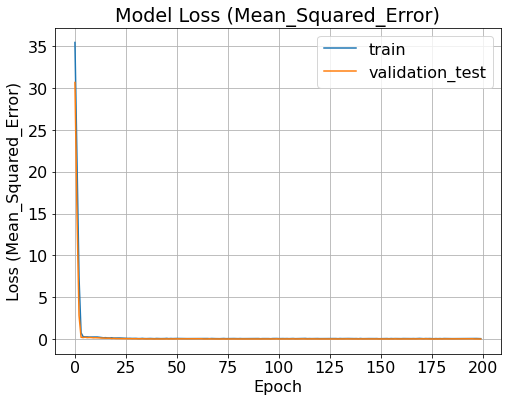

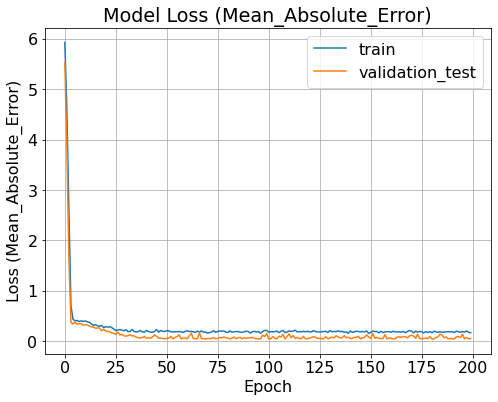

In [151]:
#For mean squared error vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Squared_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Squared_Error)')
plt.show()

#For mean absolute error vs epoch
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Absolute_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Absolute_Error)')
plt.show()

# Testing the Model using train set

In [152]:
predictions_on_trained_data = model.predict(x=train_x, batch_size=10)
#print('Predicted values : ', predictions_on_trained_data)
#print('Actual values : ', train_y)


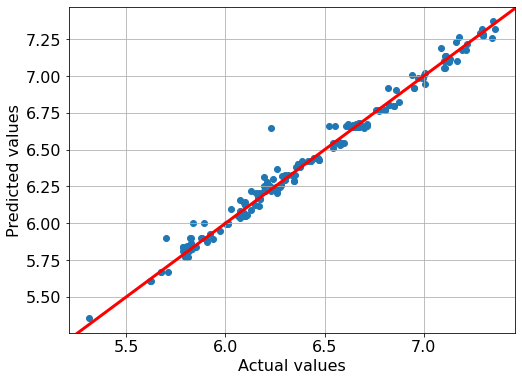

In [167]:
plt.scatter(train_y, predictions_on_trained_data)
#plt.plot([2.5, 3.5, 4.5, 6,10], [2.5, 3.5, 4.5, 6,10], 'r') # y=x line
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='red', lw=3, scalex=False, scaley=False)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.grid()
plt.show()


In [168]:
predictions = model.predict(x=test_x, batch_size=10)
#print('Predicted  values : ', predictions)
#print('Actual values : ', test_y)


# Testing the Model using test set

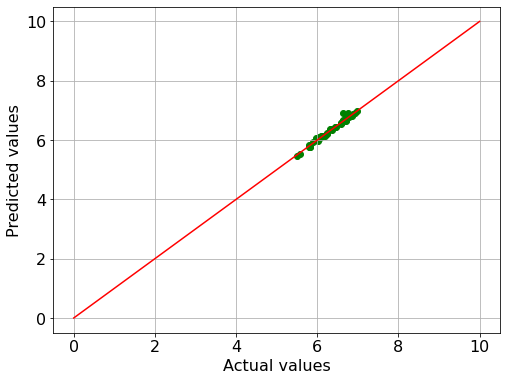

In [169]:
plt.scatter(test_y, predictions,color='green')
plt.plot([0,2.5, 3.5, 4.5, 6,10], [0,2.5, 3.5, 4.5, 6,10], 'r') # y=x line

plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.grid()
plt.show()

# Graphical comparison of prediction on train and test datasets

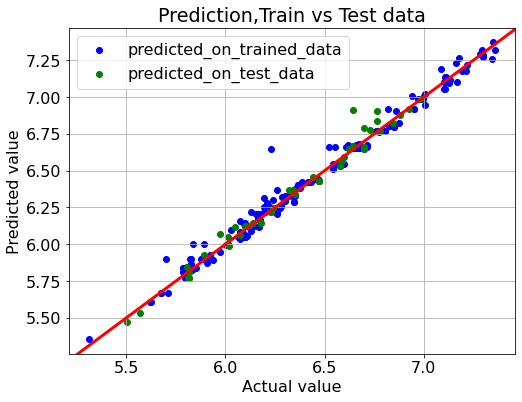

R squared value on trained data is 0.9848091274178461
R squared value on   test  data is 0.9768441662581536


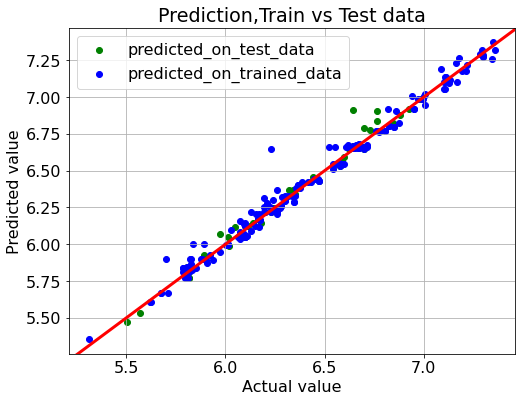

In [171]:
#Highlighting predictions on test data(green dots)
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.scatter(test_y, predictions, color='g')
plt.legend(['predicted_on_trained_data' , 'predicted_on_test_data'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='red', lw=3, scalex=False, scaley=False)
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.grid()
plt.show()

#R_Squared Values
r_squared = r2_score(train_y, predictions_on_trained_data)
print('R squared value on trained data is', r_squared)
r_squared = r2_score(test_y, predictions)
print('R squared value on   test  data is', r_squared)


#Highlighting predictions on trained data(blue dots)
plt.scatter(test_y, predictions, color='g')
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.legend(['predicted_on_test_data' , 'predicted_on_trained_data'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='red', lw=3, scalex=False, scaley=False)
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.grid()
plt.show()

# 2) ENERGY BAND GAP MODEL

In [193]:
train_x, test_x, train_y, test_y =train_test_split(fingerprint , dataframe.iloc[:,1] , test_size = 0.2, random_state = 42)

In [194]:
train_y = np.array(train_y)
print(type(train_y))

test_y = np.array(test_y)
print(type(test_y))

train_x = np.array(train_x)
print(type(train_y))

test_x = np.array(test_x)
print(type(train_y))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [195]:
train_x =np.asarray(train_x).astype(np.float64)

train_y =np.asarray(train_y).astype(np.float64)

test_x =np.asarray(test_x).astype(np.float64)

test_y =np.asarray(test_y).astype(np.float64)

In [196]:
print(train_x.shape , train_y .shape)
print(test_x.shape , test_y .shape)


(172, 3) (172,)
(43, 3) (43,)


# MODEL

In [197]:
model = Sequential()
model.add(Dense(1000, input_dim=3, activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
model.add(Dense(500,  activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

In [198]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1000)              4000      
_________________________________________________________________
dropout_19 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_20 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 501       
Total params: 505,001
Trainable params: 505,001
Non-trainable params: 0
_________________________________________________________________


In [199]:
model.compile(optimizer= 'Adam', loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])

In [200]:
history = model.fit(train_x, train_y, batch_size=5, epochs=200, validation_split = 0.2, shuffle=True, verbose=2)

Epoch 1/200
28/28 - 1s - loss: 5.4555 - mean_squared_error: 5.4555 - mean_absolute_error: 1.9108 - val_loss: 1.7184 - val_mean_squared_error: 1.7184 - val_mean_absolute_error: 1.1365
Epoch 2/200
28/28 - 0s - loss: 1.6009 - mean_squared_error: 1.6009 - mean_absolute_error: 1.0255 - val_loss: 1.2530 - val_mean_squared_error: 1.2530 - val_mean_absolute_error: 0.9765
Epoch 3/200
28/28 - 0s - loss: 0.9890 - mean_squared_error: 0.9890 - mean_absolute_error: 0.8197 - val_loss: 0.8633 - val_mean_squared_error: 0.8633 - val_mean_absolute_error: 0.7511
Epoch 4/200
28/28 - 0s - loss: 0.7861 - mean_squared_error: 0.7861 - mean_absolute_error: 0.7222 - val_loss: 0.8844 - val_mean_squared_error: 0.8844 - val_mean_absolute_error: 0.7475
Epoch 5/200
28/28 - 0s - loss: 0.7400 - mean_squared_error: 0.7400 - mean_absolute_error: 0.6804 - val_loss: 1.0653 - val_mean_squared_error: 1.0653 - val_mean_absolute_error: 0.7954
Epoch 6/200
28/28 - 0s - loss: 0.7139 - mean_squared_error: 0.7139 - mean_absolute_er

Epoch 46/200
28/28 - 1s - loss: 0.7285 - mean_squared_error: 0.7285 - mean_absolute_error: 0.6622 - val_loss: 0.7778 - val_mean_squared_error: 0.7778 - val_mean_absolute_error: 0.7100
Epoch 47/200
28/28 - 0s - loss: 0.5878 - mean_squared_error: 0.5878 - mean_absolute_error: 0.6097 - val_loss: 0.7601 - val_mean_squared_error: 0.7601 - val_mean_absolute_error: 0.7021
Epoch 48/200
28/28 - 0s - loss: 0.5411 - mean_squared_error: 0.5411 - mean_absolute_error: 0.6120 - val_loss: 0.7755 - val_mean_squared_error: 0.7755 - val_mean_absolute_error: 0.7043
Epoch 49/200
28/28 - 0s - loss: 0.6168 - mean_squared_error: 0.6168 - mean_absolute_error: 0.6267 - val_loss: 0.7706 - val_mean_squared_error: 0.7706 - val_mean_absolute_error: 0.6919
Epoch 50/200
28/28 - 0s - loss: 0.5929 - mean_squared_error: 0.5929 - mean_absolute_error: 0.6127 - val_loss: 0.8568 - val_mean_squared_error: 0.8568 - val_mean_absolute_error: 0.7131
Epoch 51/200
28/28 - 0s - loss: 0.6606 - mean_squared_error: 0.6606 - mean_absol

Epoch 91/200
28/28 - 0s - loss: 0.6091 - mean_squared_error: 0.6091 - mean_absolute_error: 0.6141 - val_loss: 0.7624 - val_mean_squared_error: 0.7624 - val_mean_absolute_error: 0.6983
Epoch 92/200
28/28 - 0s - loss: 0.6084 - mean_squared_error: 0.6084 - mean_absolute_error: 0.6003 - val_loss: 0.7452 - val_mean_squared_error: 0.7452 - val_mean_absolute_error: 0.7051
Epoch 93/200
28/28 - 0s - loss: 0.5373 - mean_squared_error: 0.5373 - mean_absolute_error: 0.5717 - val_loss: 0.8542 - val_mean_squared_error: 0.8542 - val_mean_absolute_error: 0.7111
Epoch 94/200
28/28 - 0s - loss: 0.5480 - mean_squared_error: 0.5480 - mean_absolute_error: 0.5754 - val_loss: 0.7420 - val_mean_squared_error: 0.7420 - val_mean_absolute_error: 0.6901
Epoch 95/200
28/28 - 0s - loss: 0.6660 - mean_squared_error: 0.6660 - mean_absolute_error: 0.6464 - val_loss: 0.7617 - val_mean_squared_error: 0.7617 - val_mean_absolute_error: 0.6935
Epoch 96/200
28/28 - 0s - loss: 0.6543 - mean_squared_error: 0.6543 - mean_absol

Epoch 136/200
28/28 - 0s - loss: 0.5401 - mean_squared_error: 0.5401 - mean_absolute_error: 0.5885 - val_loss: 0.8787 - val_mean_squared_error: 0.8787 - val_mean_absolute_error: 0.7305
Epoch 137/200
28/28 - 0s - loss: 0.6103 - mean_squared_error: 0.6103 - mean_absolute_error: 0.6165 - val_loss: 0.7574 - val_mean_squared_error: 0.7574 - val_mean_absolute_error: 0.6722
Epoch 138/200
28/28 - 0s - loss: 0.6642 - mean_squared_error: 0.6642 - mean_absolute_error: 0.6408 - val_loss: 0.7339 - val_mean_squared_error: 0.7339 - val_mean_absolute_error: 0.6863
Epoch 139/200
28/28 - 0s - loss: 0.6168 - mean_squared_error: 0.6168 - mean_absolute_error: 0.6264 - val_loss: 0.7222 - val_mean_squared_error: 0.7222 - val_mean_absolute_error: 0.6845
Epoch 140/200
28/28 - 0s - loss: 0.4524 - mean_squared_error: 0.4524 - mean_absolute_error: 0.5379 - val_loss: 0.7097 - val_mean_squared_error: 0.7097 - val_mean_absolute_error: 0.6706
Epoch 141/200
28/28 - 0s - loss: 0.5438 - mean_squared_error: 0.5438 - mean

Epoch 181/200
28/28 - 0s - loss: 0.5114 - mean_squared_error: 0.5114 - mean_absolute_error: 0.5740 - val_loss: 0.7930 - val_mean_squared_error: 0.7930 - val_mean_absolute_error: 0.7034
Epoch 182/200
28/28 - 0s - loss: 0.5471 - mean_squared_error: 0.5471 - mean_absolute_error: 0.5856 - val_loss: 0.9715 - val_mean_squared_error: 0.9715 - val_mean_absolute_error: 0.7721
Epoch 183/200
28/28 - 0s - loss: 0.5841 - mean_squared_error: 0.5841 - mean_absolute_error: 0.6121 - val_loss: 0.7274 - val_mean_squared_error: 0.7274 - val_mean_absolute_error: 0.6759
Epoch 184/200
28/28 - 0s - loss: 0.5226 - mean_squared_error: 0.5226 - mean_absolute_error: 0.5883 - val_loss: 0.7448 - val_mean_squared_error: 0.7448 - val_mean_absolute_error: 0.6673
Epoch 185/200
28/28 - 1s - loss: 0.4761 - mean_squared_error: 0.4761 - mean_absolute_error: 0.5554 - val_loss: 0.7123 - val_mean_squared_error: 0.7123 - val_mean_absolute_error: 0.6671
Epoch 186/200
28/28 - 0s - loss: 0.5085 - mean_squared_error: 0.5085 - mean

# LOSS FUNCTION

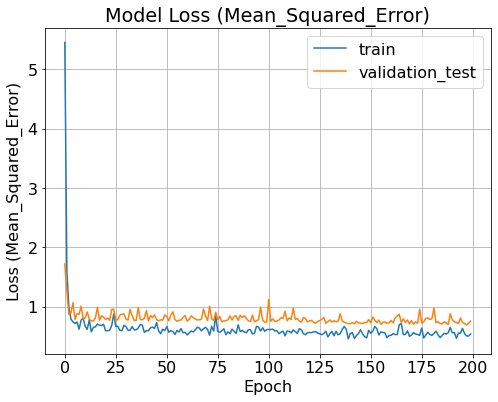

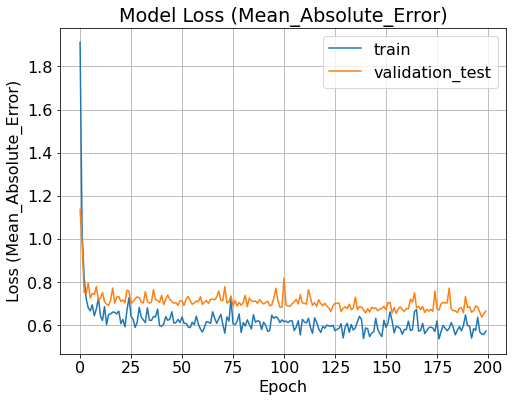

In [205]:
#For mean squared error vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Squared_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Squared_Error)')
plt.show()

#For mean absolute error vs epoch
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Absolute_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Absolute_Error)')
plt.show()

# Testing the Model using train set

In [202]:
predictions_on_trained_data = model.predict(train_x)
#print('Predicted values : ', predictions_on_trained_data)
#print('Actual values : ', train_y)

# Testing the Model using test set

In [203]:
predictions = model.predict(x=test_x, batch_size=10)
#print('Predicted  values : ', predictions)
#print('Actual values : ', test_y)

# Graphical comparison of prediction on train and test datasets

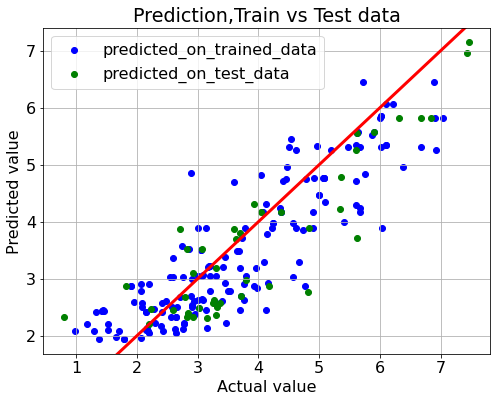

R squared value on trained data is 0.7491611399811786
R squared value on   test  data is 0.7292570423056574


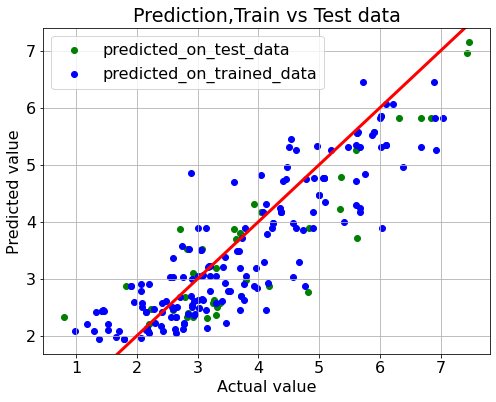

In [207]:
#Highlighting predictions on test data(green dots)
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.scatter(test_y, predictions, color='g')
plt.legend(['predicted_on_trained_data' , 'predicted_on_test_data'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='red', lw=3, scalex=False, scaley=False) #y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.grid()
plt.show()

#R_Squared Values
r_squared = r2_score(train_y, predictions_on_trained_data)
print('R squared value on trained data is', r_squared)
r_squared = r2_score(test_y, predictions)
print('R squared value on   test  data is', r_squared)


#Highlighting predictions on trained data(blue dots)
plt.scatter(test_y, predictions, color='g')
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.legend(['predicted_on_test_data' , 'predicted_on_trained_data'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='red', lw=3, scalex=False, scaley=False)   #y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.grid()
plt.show()

# 3) ELECTRONIC PART OF DIELECTRIC CONSTANT MODEL

In [104]:
train_x, test_x, train_y, test_y =train_test_split(fingerprint , dataframe.iloc[:,2] , test_size = 0.2, random_state = 42)


In [105]:
train_y = np.array(train_y)
print(type(train_y))

test_y = np.array(test_y)
print(type(test_y))

train_x = np.array(train_x)
print(type(train_y))

test_x = np.array(test_x)
print(type(train_y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [106]:
train_x =np.asarray(train_x).astype(np.float64)

train_y =np.asarray(train_y).astype(np.float64)

test_x =np.asarray(test_x).astype(np.float64)

test_y =np.asarray(test_y).astype(np.float64)

In [107]:
print(train_x.shape , train_y .shape)
print(test_x.shape , test_y .shape)

(172, 3) (172,)
(43, 3) (43,)


# MODEL

In [108]:
model = Sequential()
model.add(Dense(2000, input_dim=3, activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
#model.add(Dense(700,  activation='relu'))
#model.add(Dropout(0.2, input_shape=(3,)))
#model.add(Dense(500, activation='relu'))
#model.add(Dense(300, activation='relu'))
model.add(Dense(1, activation='linear'))

In [109]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 2000)              8000      
_________________________________________________________________
dropout_11 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 2001      
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


In [110]:
model.compile(optimizer= 'Adam', loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])

In [111]:
history = model.fit(train_x, train_y, batch_size=5, epochs=200, validation_split = 0.2, shuffle=True, verbose=2)

Epoch 1/200
28/28 - 1s - loss: 4.5513 - mean_squared_error: 4.5513 - mean_absolute_error: 2.0078 - val_loss: 0.7966 - val_mean_squared_error: 0.7966 - val_mean_absolute_error: 0.7768
Epoch 2/200
28/28 - 0s - loss: 0.2394 - mean_squared_error: 0.2394 - mean_absolute_error: 0.4228 - val_loss: 0.1934 - val_mean_squared_error: 0.1934 - val_mean_absolute_error: 0.3368
Epoch 3/200
28/28 - 0s - loss: 0.1183 - mean_squared_error: 0.1183 - mean_absolute_error: 0.2720 - val_loss: 0.1953 - val_mean_squared_error: 0.1953 - val_mean_absolute_error: 0.3267
Epoch 4/200
28/28 - 0s - loss: 0.1152 - mean_squared_error: 0.1152 - mean_absolute_error: 0.2814 - val_loss: 0.1915 - val_mean_squared_error: 0.1915 - val_mean_absolute_error: 0.3183
Epoch 5/200
28/28 - 0s - loss: 0.1010 - mean_squared_error: 0.1010 - mean_absolute_error: 0.2610 - val_loss: 0.1665 - val_mean_squared_error: 0.1665 - val_mean_absolute_error: 0.2992
Epoch 6/200
28/28 - 0s - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_er

Epoch 46/200
28/28 - 0s - loss: 0.0383 - mean_squared_error: 0.0383 - mean_absolute_error: 0.1377 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.1850
Epoch 47/200
28/28 - 0s - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1478 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_mean_absolute_error: 0.1893
Epoch 48/200
28/28 - 0s - loss: 0.0392 - mean_squared_error: 0.0392 - mean_absolute_error: 0.1381 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_mean_absolute_error: 0.1939
Epoch 49/200
28/28 - 0s - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1315 - val_loss: 0.0807 - val_mean_squared_error: 0.0807 - val_mean_absolute_error: 0.1871
Epoch 50/200
28/28 - 0s - loss: 0.0431 - mean_squared_error: 0.0431 - mean_absolute_error: 0.1527 - val_loss: 0.0862 - val_mean_squared_error: 0.0862 - val_mean_absolute_error: 0.1908
Epoch 51/200
28/28 - 0s - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absol

Epoch 91/200
28/28 - 0s - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.1664 - val_loss: 0.0812 - val_mean_squared_error: 0.0812 - val_mean_absolute_error: 0.1890
Epoch 92/200
28/28 - 0s - loss: 0.0398 - mean_squared_error: 0.0398 - mean_absolute_error: 0.1413 - val_loss: 0.0750 - val_mean_squared_error: 0.0750 - val_mean_absolute_error: 0.1871
Epoch 93/200
28/28 - 0s - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1341 - val_loss: 0.0790 - val_mean_squared_error: 0.0790 - val_mean_absolute_error: 0.2097
Epoch 94/200
28/28 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1487 - val_loss: 0.0897 - val_mean_squared_error: 0.0897 - val_mean_absolute_error: 0.2310
Epoch 95/200
28/28 - 0s - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1416 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.1890
Epoch 96/200
28/28 - 0s - loss: 0.0421 - mean_squared_error: 0.0421 - mean_absol

Epoch 136/200
28/28 - 0s - loss: 0.0408 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1387 - val_loss: 0.0772 - val_mean_squared_error: 0.0772 - val_mean_absolute_error: 0.1883
Epoch 137/200
28/28 - 0s - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1421 - val_loss: 0.0730 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.1886
Epoch 138/200
28/28 - 0s - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1388 - val_loss: 0.0911 - val_mean_squared_error: 0.0911 - val_mean_absolute_error: 0.2057
Epoch 139/200
28/28 - 0s - loss: 0.0417 - mean_squared_error: 0.0417 - mean_absolute_error: 0.1482 - val_loss: 0.0753 - val_mean_squared_error: 0.0753 - val_mean_absolute_error: 0.1838
Epoch 140/200
28/28 - 0s - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1427 - val_loss: 0.0730 - val_mean_squared_error: 0.0730 - val_mean_absolute_error: 0.1856
Epoch 141/200
28/28 - 0s - loss: 0.0429 - mean_squared_error: 0.0429 - mean

Epoch 181/200
28/28 - 0s - loss: 0.0515 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1832 - val_loss: 0.0819 - val_mean_squared_error: 0.0819 - val_mean_absolute_error: 0.2204
Epoch 182/200
28/28 - 0s - loss: 0.0380 - mean_squared_error: 0.0380 - mean_absolute_error: 0.1354 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.1918
Epoch 183/200
28/28 - 0s - loss: 0.0373 - mean_squared_error: 0.0373 - mean_absolute_error: 0.1361 - val_loss: 0.0835 - val_mean_squared_error: 0.0835 - val_mean_absolute_error: 0.2224
Epoch 184/200
28/28 - 0s - loss: 0.0498 - mean_squared_error: 0.0498 - mean_absolute_error: 0.1682 - val_loss: 0.0729 - val_mean_squared_error: 0.0729 - val_mean_absolute_error: 0.1915
Epoch 185/200
28/28 - 0s - loss: 0.0412 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1503 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_mean_absolute_error: 0.1975
Epoch 186/200
28/28 - 0s - loss: 0.0400 - mean_squared_error: 0.0400 - mean

# LOSS FUNCTION

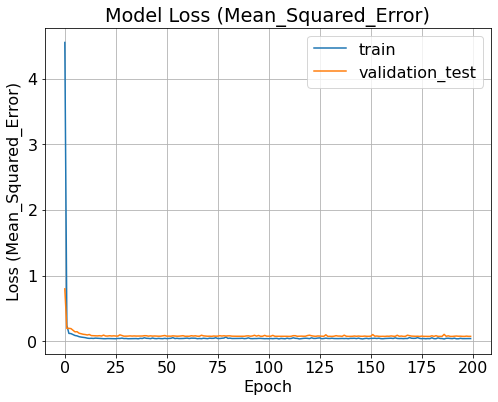

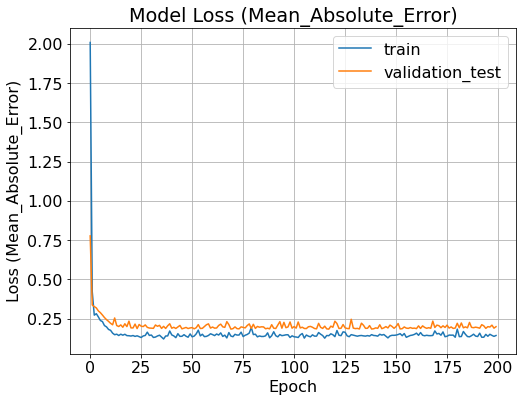

In [112]:
#For mean squared error vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Squared_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Squared_Error)')
plt.show()

#For mean absolute error vs epoch
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Absolute_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Absolute_Error)')
plt.show()

# Testing the Model using train set

In [113]:
predictions_on_trained_data = model.predict(x=train_x, batch_size=10)
#print('Predicted values : ', predictions_on_trained_data)
#print('Actual values : ', train_y)

# Testing the Model using test set

In [114]:
predictions = model.predict(x=test_x, batch_size=10)
#print('Predicted  values : ', predictions)
#print('Actual values : ', test_y)

# Graphical comparison of prediction on train and test datasets

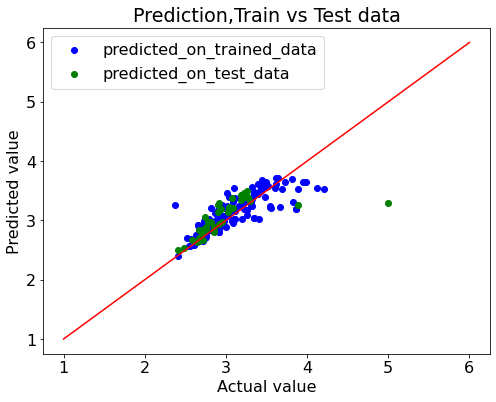

R squared value on trained data is 0.709644718414773
R squared value on   test  data is 0.3941605915421591


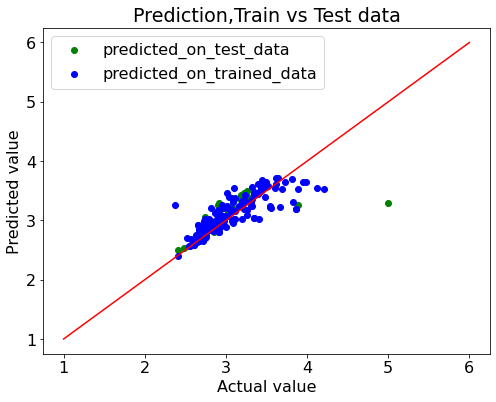

In [115]:
#Highlighting predictions on test data(green dots)
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.scatter(test_y, predictions, color='g')
plt.legend(['predicted_on_trained_data' , 'predicted_on_test_data'])
plt.plot([1,2.5, 3.5, 4.5, 6], [1,2.5, 3.5, 4.5, 6 ], 'r') # y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

#R_Squared Values
r_squared = r2_score(train_y, predictions_on_trained_data)
print('R squared value on trained data is', r_squared)
r_squared = r2_score(test_y, predictions)
print('R squared value on   test  data is', r_squared)


#Highlighting predictions on trained data(blue dots)
plt.scatter(test_y, predictions, color='g')
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.legend(['predicted_on_test_data' , 'predicted_on_trained_data'])
plt.plot([1,2.5, 3.5, 4.5, 6], [1,2.5, 3.5, 4.5, 6], 'r') # y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

# 4) IONIC PART OF DIELECTRIC CONSTANT MODEL

In [116]:
train_x, test_x, train_y, test_y =train_test_split(fingerprint , dataframe.iloc[:,3] , test_size = 0.2, random_state = 42)

In [117]:
train_y = np.array(train_y)
print(type(train_y))

test_y = np.array(test_y)
print(type(test_y))

train_x = np.array(train_x)
print(type(train_y))

test_x = np.array(test_x)
print(type(train_y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [118]:
train_x =np.asarray(train_x).astype(np.float64)

train_y =np.asarray(train_y).astype(np.float64)

test_x =np.asarray(test_x).astype(np.float64)

test_y =np.asarray(test_y).astype(np.float64)

In [119]:
print(train_x.shape , train_y .shape)
print(test_x.shape , test_y .shape)

(172, 3) (172,)
(43, 3) (43,)


# MODEL

In [120]:
model = Sequential()
model.add(Dense(1000, input_dim=3, activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
model.add(Dense(500,  activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

In [121]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1000)              4000      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 500)               500500    
_________________________________________________________________
dropout_13 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 501       
Total params: 505,001
Trainable params: 505,001
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.compile(optimizer= 'Adam', loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])

In [123]:
history = model.fit(train_x, train_y, batch_size=5, epochs=200, validation_split = 0.2, shuffle=True, verbose=2)

Epoch 1/200
28/28 - 1s - loss: 0.0920 - mean_squared_error: 0.0920 - mean_absolute_error: 0.2368 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_mean_absolute_error: 0.1405
Epoch 2/200
28/28 - 0s - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1286 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1495
Epoch 3/200
28/28 - 0s - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1463 - val_loss: 0.0542 - val_mean_squared_error: 0.0542 - val_mean_absolute_error: 0.2021
Epoch 4/200
28/28 - 1s - loss: 0.0354 - mean_squared_error: 0.0354 - mean_absolute_error: 0.1476 - val_loss: 0.0550 - val_mean_squared_error: 0.0550 - val_mean_absolute_error: 0.2018
Epoch 5/200
28/28 - 0s - loss: 0.0424 - mean_squared_error: 0.0424 - mean_absolute_error: 0.1580 - val_loss: 0.0491 - val_mean_squared_error: 0.0491 - val_mean_absolute_error: 0.1376
Epoch 6/200
28/28 - 0s - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_er

Epoch 46/200
28/28 - 0s - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1257 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.2051
Epoch 47/200
28/28 - 0s - loss: 0.0243 - mean_squared_error: 0.0243 - mean_absolute_error: 0.1224 - val_loss: 0.0501 - val_mean_squared_error: 0.0501 - val_mean_absolute_error: 0.1531
Epoch 48/200
28/28 - 0s - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1258 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1518
Epoch 49/200
28/28 - 0s - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1095 - val_loss: 0.0448 - val_mean_squared_error: 0.0448 - val_mean_absolute_error: 0.1475
Epoch 50/200
28/28 - 0s - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1270 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1581
Epoch 51/200
28/28 - 0s - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absol

Epoch 91/200
28/28 - 0s - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1151 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1742
Epoch 92/200
28/28 - 0s - loss: 0.0219 - mean_squared_error: 0.0219 - mean_absolute_error: 0.1163 - val_loss: 0.0515 - val_mean_squared_error: 0.0515 - val_mean_absolute_error: 0.1602
Epoch 93/200
28/28 - 0s - loss: 0.0204 - mean_squared_error: 0.0204 - mean_absolute_error: 0.1095 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1425
Epoch 94/200
28/28 - 0s - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1092 - val_loss: 0.0518 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1857
Epoch 95/200
28/28 - 0s - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1275 - val_loss: 0.0465 - val_mean_squared_error: 0.0465 - val_mean_absolute_error: 0.1486
Epoch 96/200
28/28 - 0s - loss: 0.0193 - mean_squared_error: 0.0193 - mean_absol

Epoch 136/200
28/28 - 0s - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1070 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1557
Epoch 137/200
28/28 - 0s - loss: 0.0190 - mean_squared_error: 0.0190 - mean_absolute_error: 0.1071 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.1505
Epoch 138/200
28/28 - 0s - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.1000 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1551
Epoch 139/200
28/28 - 0s - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1107 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1722
Epoch 140/200
28/28 - 0s - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1160 - val_loss: 0.0474 - val_mean_squared_error: 0.0474 - val_mean_absolute_error: 0.1579
Epoch 141/200
28/28 - 0s - loss: 0.0191 - mean_squared_error: 0.0191 - mean

Epoch 181/200
28/28 - 0s - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1072 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.1663
Epoch 182/200
28/28 - 1s - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.1047 - val_loss: 0.0479 - val_mean_squared_error: 0.0479 - val_mean_absolute_error: 0.1543
Epoch 183/200
28/28 - 1s - loss: 0.0172 - mean_squared_error: 0.0172 - mean_absolute_error: 0.1018 - val_loss: 0.0530 - val_mean_squared_error: 0.0530 - val_mean_absolute_error: 0.1500
Epoch 184/200
28/28 - 1s - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1088 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1603
Epoch 185/200
28/28 - 0s - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.0979 - val_loss: 0.0489 - val_mean_squared_error: 0.0489 - val_mean_absolute_error: 0.1541
Epoch 186/200
28/28 - 0s - loss: 0.0194 - mean_squared_error: 0.0194 - mean

# LOSS FUNCTION

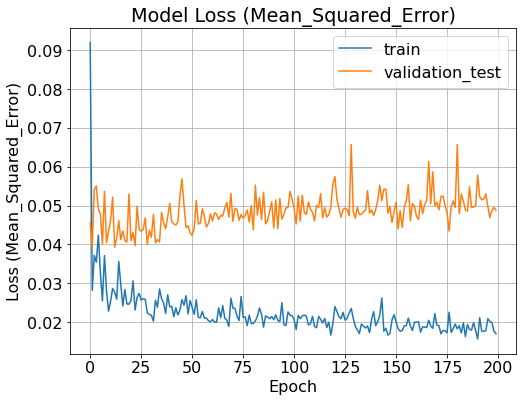

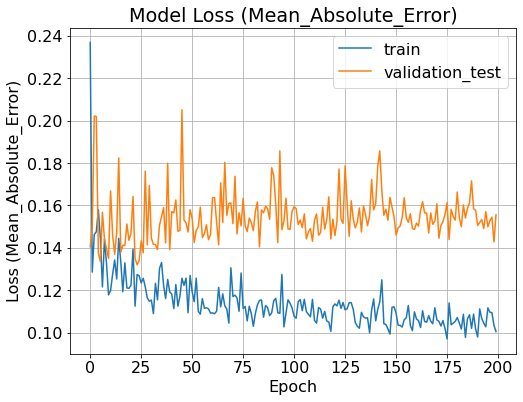

In [124]:
#For mean squared error vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Squared_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Squared_Error)')
plt.show()

#For mean absolute error vs epoch
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Absolute_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Absolute_Error)')
plt.show()

# Testing the Model using train set

In [125]:
predictions_on_trained_data = model.predict(x=train_x, batch_size=10)
#print('Predicted values : ', predictions_on_trained_data)
#print('Actual values : ', train_y)

# Testing the Model using test set

In [126]:
predictions = model.predict(x=test_x, batch_size=10)
#print('Predicted  values : ', predictions)
#print('Actual values : ', test_y)

# Graphical comparison of prediction on train and test datasets

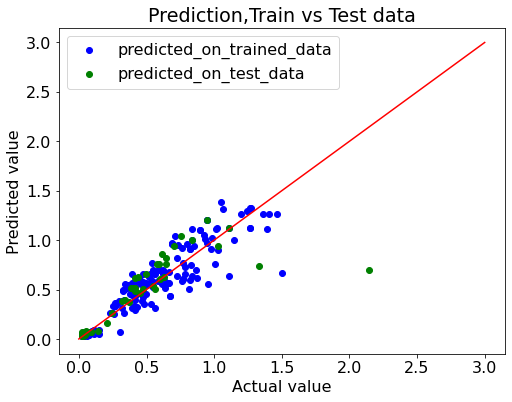

R squared value on trained data is 0.7990656878276772
R squared value on   test  data is 0.5821503603897313


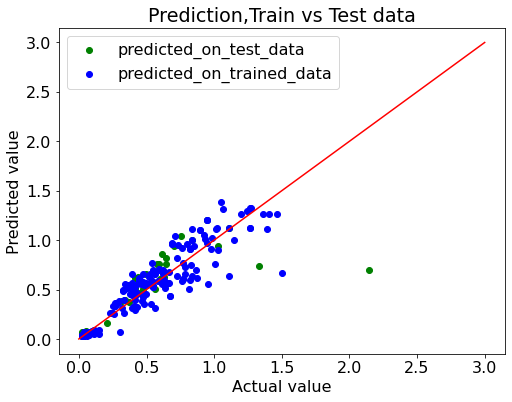

In [127]:
#Highlighting predictions on test data(green dots)
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.scatter(test_y, predictions, color='g')
plt.legend(['predicted_on_trained_data' , 'predicted_on_test_data'])
plt.plot([0,2.5, 3.0], [0,2.5, 3.0], 'r') # y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

#R_Squared Values
r_squared = r2_score(train_y, predictions_on_trained_data)
print('R squared value on trained data is', r_squared)
r_squared = r2_score(test_y, predictions)
print('R squared value on   test  data is', r_squared)


#Highlighting predictions on trained data(blue dots)
plt.scatter(test_y, predictions, color='g')
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.legend(['predicted_on_test_data' , 'predicted_on_trained_data'])
plt.plot([0,2.5, 3.0], [0,2.5, 3.0], 'r') # y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

# 5) TOTAL DIELECTRIC CONSTANT MODEL

In [128]:
train_x, test_x, train_y, test_y =train_test_split(fingerprint , dataframe.iloc[:,4] , test_size = 0.2, random_state = 42)

In [129]:
train_y = np.array(train_y)
print(type(train_y))

test_y = np.array(test_y)
print(type(test_y))

train_x = np.array(train_x)
print(type(train_y))

test_x = np.array(test_x)
print(type(train_y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [130]:
train_x =np.asarray(train_x).astype(np.float64)

train_y =np.asarray(train_y).astype(np.float64)

test_x =np.asarray(test_x).astype(np.float64)

test_y =np.asarray(test_y).astype(np.float64)

In [131]:
print(train_x.shape , train_y .shape)
print(test_x.shape , test_y .shape)

(172, 3) (172,)
(43, 3) (43,)


# MODEL

In [132]:
model = Sequential()
model.add(Dense(1200, input_dim=3, activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
model.add(Dense(500,  activation='relu'))
model.add(Dropout(0.2, input_shape=(3,)))
#model.add(Dense(100, activation='relu'))
#model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

In [133]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1200)              4800      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 500)               600500    
_________________________________________________________________
dropout_15 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 501       
Total params: 605,801
Trainable params: 605,801
Non-trainable params: 0
_________________________________________________________________


In [134]:
model.compile(optimizer= 'Adam', loss='mean_squared_error', metrics=['mean_squared_error','mean_absolute_error'])

In [135]:
history = model.fit(train_x, train_y, batch_size=5, epochs=200, validation_split = 0.2, shuffle=True, verbose=2)

Epoch 1/200
28/28 - 1s - loss: 3.1509 - mean_squared_error: 3.1509 - mean_absolute_error: 1.3528 - val_loss: 0.8624 - val_mean_squared_error: 0.8624 - val_mean_absolute_error: 0.7281
Epoch 2/200
28/28 - 0s - loss: 0.2910 - mean_squared_error: 0.2910 - mean_absolute_error: 0.4122 - val_loss: 0.2440 - val_mean_squared_error: 0.2440 - val_mean_absolute_error: 0.3323
Epoch 3/200
28/28 - 0s - loss: 0.1501 - mean_squared_error: 0.1501 - mean_absolute_error: 0.2988 - val_loss: 0.1627 - val_mean_squared_error: 0.1627 - val_mean_absolute_error: 0.3226
Epoch 4/200
28/28 - 0s - loss: 0.1020 - mean_squared_error: 0.1020 - mean_absolute_error: 0.2430 - val_loss: 0.1490 - val_mean_squared_error: 0.1490 - val_mean_absolute_error: 0.2962
Epoch 5/200
28/28 - 0s - loss: 0.1207 - mean_squared_error: 0.1207 - mean_absolute_error: 0.2685 - val_loss: 0.1521 - val_mean_squared_error: 0.1521 - val_mean_absolute_error: 0.3101
Epoch 6/200
28/28 - 0s - loss: 0.1111 - mean_squared_error: 0.1111 - mean_absolute_er

Epoch 46/200
28/28 - 1s - loss: 0.1243 - mean_squared_error: 0.1243 - mean_absolute_error: 0.2745 - val_loss: 0.1642 - val_mean_squared_error: 0.1642 - val_mean_absolute_error: 0.2784
Epoch 47/200
28/28 - 0s - loss: 0.1134 - mean_squared_error: 0.1134 - mean_absolute_error: 0.2627 - val_loss: 0.1885 - val_mean_squared_error: 0.1885 - val_mean_absolute_error: 0.3004
Epoch 48/200
28/28 - 0s - loss: 0.1235 - mean_squared_error: 0.1235 - mean_absolute_error: 0.2689 - val_loss: 0.1456 - val_mean_squared_error: 0.1456 - val_mean_absolute_error: 0.2641
Epoch 49/200
28/28 - 0s - loss: 0.1136 - mean_squared_error: 0.1136 - mean_absolute_error: 0.2531 - val_loss: 0.1327 - val_mean_squared_error: 0.1327 - val_mean_absolute_error: 0.2643
Epoch 50/200
28/28 - 0s - loss: 0.1323 - mean_squared_error: 0.1323 - mean_absolute_error: 0.2777 - val_loss: 0.1258 - val_mean_squared_error: 0.1258 - val_mean_absolute_error: 0.2721
Epoch 51/200
28/28 - 0s - loss: 0.1598 - mean_squared_error: 0.1598 - mean_absol

Epoch 91/200
28/28 - 0s - loss: 0.1200 - mean_squared_error: 0.1200 - mean_absolute_error: 0.2711 - val_loss: 0.1294 - val_mean_squared_error: 0.1294 - val_mean_absolute_error: 0.2749
Epoch 92/200
28/28 - 0s - loss: 0.1024 - mean_squared_error: 0.1024 - mean_absolute_error: 0.2400 - val_loss: 0.1392 - val_mean_squared_error: 0.1392 - val_mean_absolute_error: 0.2998
Epoch 93/200
28/28 - 0s - loss: 0.1261 - mean_squared_error: 0.1261 - mean_absolute_error: 0.2728 - val_loss: 0.1229 - val_mean_squared_error: 0.1229 - val_mean_absolute_error: 0.2670
Epoch 94/200
28/28 - 0s - loss: 0.1131 - mean_squared_error: 0.1131 - mean_absolute_error: 0.2632 - val_loss: 0.1262 - val_mean_squared_error: 0.1262 - val_mean_absolute_error: 0.2762
Epoch 95/200
28/28 - 0s - loss: 0.1039 - mean_squared_error: 0.1039 - mean_absolute_error: 0.2517 - val_loss: 0.1730 - val_mean_squared_error: 0.1730 - val_mean_absolute_error: 0.3003
Epoch 96/200
28/28 - 0s - loss: 0.1300 - mean_squared_error: 0.1300 - mean_absol

Epoch 136/200
28/28 - 0s - loss: 0.1086 - mean_squared_error: 0.1086 - mean_absolute_error: 0.2636 - val_loss: 0.1860 - val_mean_squared_error: 0.1860 - val_mean_absolute_error: 0.3189
Epoch 137/200
28/28 - 0s - loss: 0.1180 - mean_squared_error: 0.1180 - mean_absolute_error: 0.2610 - val_loss: 0.3001 - val_mean_squared_error: 0.3001 - val_mean_absolute_error: 0.4043
Epoch 138/200
28/28 - 0s - loss: 0.1133 - mean_squared_error: 0.1133 - mean_absolute_error: 0.2635 - val_loss: 0.1785 - val_mean_squared_error: 0.1785 - val_mean_absolute_error: 0.2863
Epoch 139/200
28/28 - 0s - loss: 0.1331 - mean_squared_error: 0.1331 - mean_absolute_error: 0.2753 - val_loss: 0.1444 - val_mean_squared_error: 0.1444 - val_mean_absolute_error: 0.2790
Epoch 140/200
28/28 - 1s - loss: 0.1121 - mean_squared_error: 0.1121 - mean_absolute_error: 0.2468 - val_loss: 0.1301 - val_mean_squared_error: 0.1301 - val_mean_absolute_error: 0.2799
Epoch 141/200
28/28 - 0s - loss: 0.1222 - mean_squared_error: 0.1222 - mean

Epoch 181/200
28/28 - 1s - loss: 0.1083 - mean_squared_error: 0.1083 - mean_absolute_error: 0.2513 - val_loss: 0.1285 - val_mean_squared_error: 0.1285 - val_mean_absolute_error: 0.2767
Epoch 182/200
28/28 - 0s - loss: 0.1122 - mean_squared_error: 0.1122 - mean_absolute_error: 0.2529 - val_loss: 0.1204 - val_mean_squared_error: 0.1204 - val_mean_absolute_error: 0.2556
Epoch 183/200
28/28 - 0s - loss: 0.1069 - mean_squared_error: 0.1069 - mean_absolute_error: 0.2549 - val_loss: 0.1474 - val_mean_squared_error: 0.1474 - val_mean_absolute_error: 0.2819
Epoch 184/200
28/28 - 0s - loss: 0.1123 - mean_squared_error: 0.1123 - mean_absolute_error: 0.2531 - val_loss: 0.1941 - val_mean_squared_error: 0.1941 - val_mean_absolute_error: 0.3149
Epoch 185/200
28/28 - 0s - loss: 0.1008 - mean_squared_error: 0.1008 - mean_absolute_error: 0.2382 - val_loss: 0.1224 - val_mean_squared_error: 0.1224 - val_mean_absolute_error: 0.2754
Epoch 186/200
28/28 - 0s - loss: 0.1055 - mean_squared_error: 0.1055 - mean

# LOSS FUNCTION

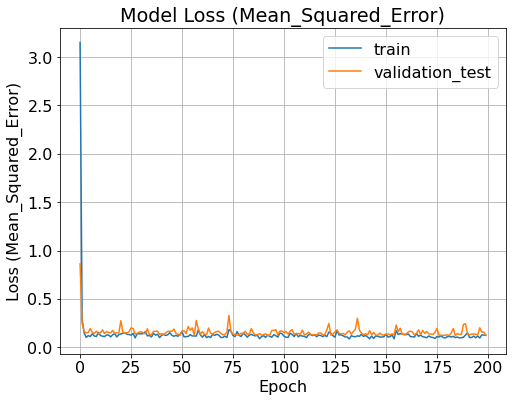

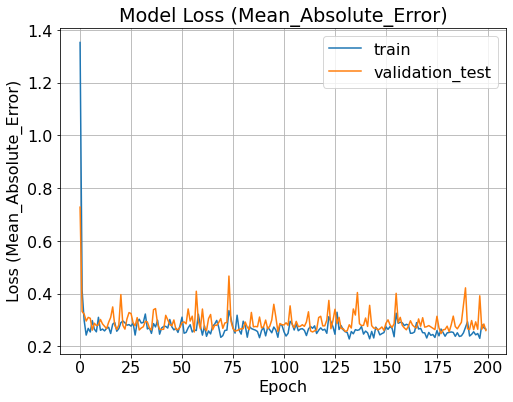

In [136]:
#For mean squared error vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Squared_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Squared_Error)')
plt.show()

#For mean absolute error vs epoch
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.legend(['train' , 'validation_test'])
plt.grid(True)
plt.title('Model Loss (Mean_Absolute_Error)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean_Absolute_Error)')
plt.show()

# Testing the Model using train set

In [137]:
predictions_on_trained_data = model.predict(x=train_x, batch_size=10)
#print('Predicted values : ', predictions_on_trained_data)
#print('Actual values : ', train_y)

# Testing the Model using test set

In [138]:
predictions = model.predict(x=test_x, batch_size=10)
#print('Predicted  values : ', predictions)
#print('Actual values : ', test_y)

# Graphical comparison of prediction on train and test datasets

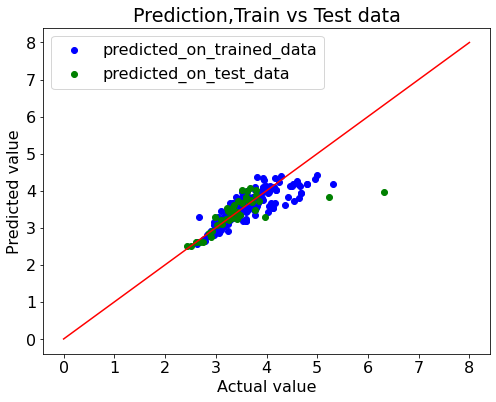

R squared value on trained data is 0.7055409665755161
R squared value on   test  data is 0.47269579889337976


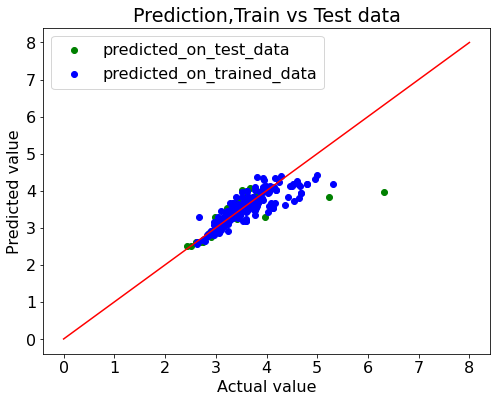

In [139]:
#Highlighting predictions on test data(green dots)
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.scatter(test_y, predictions, color='g')
plt.legend(['predicted_on_trained_data' , 'predicted_on_test_data'])
plt.plot([0,2.5, 3.0,8.0], [0,2.5, 3.0,8.0], 'r') # y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

#R_Squared Values
r_squared = r2_score(train_y, predictions_on_trained_data)
print('R squared value on trained data is', r_squared)
r_squared = r2_score(test_y, predictions)
print('R squared value on   test  data is', r_squared)


#Highlighting predictions on trained data(blue dots)
plt.scatter(test_y, predictions, color='g')
plt.scatter(train_y, predictions_on_trained_data, color='b')
plt.legend(['predicted_on_test_data' , 'predicted_on_trained_data'])
plt.plot([0,2.5, 3.0,8.0], [0,2.5, 3.0,8.0], 'r') # y=x line
plt.title('Prediction,Train vs Test data')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')
plt.show()

# CONCLUSIONS
1)This kind of fingerprinting is good for predicting Atomisation energy.R2 score exceeds 0.97 for both test and train set.

2)Accuracy of prediction decreases for other models with R2 score hovering around 0.8 for train set anf 0.8-0.4 for test set for other different models.

3)Either different fingerprints will be needed for better representation or more hyperparameter tuning is needed.Probabily former is the case here.